<a href="https://colab.research.google.com/github/GeneSUN/Anomaly_Detection_toolkit/blob/main/AE_AnomalyDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ⚠️ Heads-Up: PyOD API Changes for AutoEncoder
Recent versions of PyOD have introduced changes to the AutoEncoder module:

```
# Old:
from pyod.models.auto_encoder_torch import AutoEncoder

# New:
from pyod.models.auto_encoder import AutoEncoder

```

🔧 Parameter Name Changes
Several parameter names have been updated:

| Old Parameter       | New Parameter            |
| ------------------- | ------------------------ |
| `learning_rate`     | `lr`                     |
| `epochs`            | `epoch_num`              |
| `hidden_neurons`    | `hidden_neuron_list`     |
| `hidden_activation` | `hidden_activation_name` |

✅ Be careful when upgrading PyOD or copying older code — these changes will affect model initialization and training!



# multiple customer - single feature - short history


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from typing import Optional, Union, Tuple
# from pyod.models.auto_encoder_torch import AutoEncoder
from pyod.models.auto_encoder import AutoEncoder
from matplotlib import cm


## Prepare dataframe

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Parameters
num_series = 3000  # number of distinct slice_id
points_per_series = 100  # time steps per series
anomaly_fraction = 0.1  # fraction of series with anomalies

np.random.seed(42)

# Create time index
start_time = datetime(2025, 1, 1, 0)
time_index = [start_time + timedelta(hours=i) for i in range(points_per_series)]

# Generate normal series data
data = []
anomaly_series_ids = np.random.choice(range(num_series), int(num_series * anomaly_fraction), replace=False)

for sid in range(num_series):
    slice_id = f"S{sid:04d}"
    base = np.random.normal(loc=20, scale=3)
    noise = np.random.normal(loc=0, scale=2, size=points_per_series)
    series = base + noise

    # Inject anomaly if the slice_id is selected
    if sid in anomaly_series_ids:
        anomaly_indices = np.random.choice(points_per_series, size=5, replace=False)
        series[anomaly_indices] += np.random.normal(loc=20, scale=5, size=5)  # large spikes

    for t, val in zip(time_index, series):
        data.append([slice_id, t, val])

# Create DataFrame
df_pandas = pd.DataFrame(data, columns=["slice_id", "hour", "avg_4gsnr"])

#import ace_tools as tools; tools.display_dataframe_to_user(name="Synthetic Univariate Time Series with Anomalies", dataframe=df_univariate)


In [ ]:
"""
import pandas as pd
import numpy as np

from datetime import datetime, timedelta

# Generate synthetic data resembling df_pandas structure
np.random.seed(42)

num_slices = 3000
hours_per_slice = 100
slice_ids = [f"S{i+1}" for i in range(num_slices)]

data = []
start_time = datetime(2025, 1, 1, 0)

for slice_id in slice_ids:
    for i in range(hours_per_slice):
        timestamp = start_time + timedelta(hours=i)
        snr_value = np.random.normal(loc=20, scale=5)  # synthetic SNR values
        data.append([slice_id, timestamp, snr_value])

# Create the DataFrame
df_pandas = pd.DataFrame(data, columns=["slice_id", "hour", "avg_4gsnr"])

"""


'\nimport pandas as pd\nimport numpy as np\n\nfrom datetime import datetime, timedelta\n\n# Generate synthetic data resembling df_pandas structure\nnp.random.seed(42)\n\nnum_slices = 3000\nhours_per_slice = 100\nslice_ids = [f"S{i+1}" for i in range(num_slices)]\n\ndata = []\nstart_time = datetime(2025, 1, 1, 0)\n\nfor slice_id in slice_ids:\n    for i in range(hours_per_slice):\n        timestamp = start_time + timedelta(hours=i)\n        snr_value = np.random.normal(loc=20, scale=5)  # synthetic SNR values\n        data.append([slice_id, timestamp, snr_value])\n\n# Create the DataFrame\ndf_pandas = pd.DataFrame(data, columns=["slice_id", "hour", "avg_4gsnr"])\n\n'

In [3]:
df_pandas.iloc[2]

,2
slice_id,S0000
hour,2025-01-01 02:00:00
avg_4gsnr,15.451771


## building Model

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from typing import Optional, Union, Tuple
# from pyod.models.auto_encoder_torch import AutoEncoder
from pyod.models.auto_encoder import AutoEncoder
from matplotlib import cm

class MultiTimeSeriesAutoencoder:
    def __init__(self,
                 df: pd.DataFrame,
                 time_col: str,
                 feature: str,
                 slice_col: str = "slice_id",
                 model_params: Optional[dict] = None,
                 external_model: Optional[object] = None,
                 scaler: Union[str, object, None] = "None",
                 threshold_percentile: float = 99):
        self.df_raw = df.copy()
        self.time_col = time_col
        self.feature = feature
        self.slice_col = slice_col
        self.model_params = model_params
        self.external_model = external_model
        self.scaler_type = scaler
        self.scaler = None
        self.model = None
        self.threshold_percentile = threshold_percentile

        self.input_tensor = None
        self.input_tensor_scaled = None
        self.anomaly_scores = None
        self.threshold_scores = None

    def _build_tensor_from_slices(self):
        grouped = self.df_raw.groupby(self.slice_col)
        tensors = []

        for _, group in grouped:
            series = group.sort_values(by=self.time_col)[self.feature].values
            tensors.append(series)

        tensor_3d = np.stack(tensors)[:, :, np.newaxis]  # shape: (n_samples, n_timesteps, 1)
        return tensor_3d

    def _apply_scaler(self, X: np.ndarray) -> np.ndarray:
        if self.scaler_type is None:
            return X
        flat_X = X.reshape(-1, X.shape[-1])  # flatten across time axis
        if self.scaler_type == "standard":
            self.scaler = StandardScaler()
        elif self.scaler_type == "minmax":
            from sklearn.preprocessing import MinMaxScaler
            self.scaler = MinMaxScaler()
        else:
            self.scaler = self.scaler_type
        scaled_flat = self.scaler.fit_transform(flat_X)
        return scaled_flat.reshape(X.shape)

    def prepare(self):
        tensor = self._build_tensor_from_slices()
        self.input_tensor = tensor
        self.input_tensor_scaled = self._apply_scaler(tensor)

    def _init_model(self):
        if self.external_model:
            return self.external_model
        default_params = {
            "hidden_neuron_list": [self.input_tensor.shape[1], 32, 32, self.input_tensor.shape[1]],
            #"hidden_neurons": [self.input_tensor.shape[1], 32, 32, self.input_tensor.shape[1]],
            "hidden_activation_name": "relu",
            #"hidden_activation": "relu",
            #"epochs": 20,
            "epoch_num": 20,
            "batch_norm": True,
            "lr": 0.001,
            #"learning_rate": 0.001,
            "batch_size": 32,
            "dropout_rate": 0.2,
        }
        if self.model_params:
            default_params.update(self.model_params)
        return AutoEncoder(**default_params)

    def fit(self, threshold_percentile=None):
        if self.input_tensor_scaled is None:
            raise ValueError("Call prepare() before fit().")
        if threshold_percentile is None:
            threshold_percentile = self.threshold_percentile

        n_samples = self.input_tensor_scaled.shape[0]
        X = self.input_tensor_scaled.reshape(n_samples, -1)  # flatten to 2D for sklearn-compatible model
        self.model = self._init_model()
        self.model.fit(X)

        self.anomaly_scores = self.model.decision_scores_
        self.threshold_scores = np.percentile(self.anomaly_scores, threshold_percentile)

    def get_anomaly_stats(self):
        """
        Return anomaly scores and labels per slice (1 row per slice_id).

        Returns
        -------
        pd.DataFrame
            A DataFrame with columns ['sn', slice_col, 'anomaly_score', 'is_outlier']
        """
        if self.anomaly_scores is None:
            raise ValueError("Call fit() first.")

        is_outlier = self.anomaly_scores > self.threshold_scores

        unique_slices = self.df_raw[[self.slice_col]].drop_duplicates().reset_index(drop=True)
        result_df = unique_slices.copy()
        result_df["anomaly_score"] = self.anomaly_scores
        result_df["is_outlier"] = is_outlier
        result_df["sn"] = result_df[self.slice_col].apply(lambda x: str(x).split("_")[0])

        return result_df[["sn", self.slice_col, "anomaly_score", "is_outlier"]]

    def predict_score_and_label(self, input_array: np.ndarray, threshold: float = None):
        """
        Predict anomaly scores and labels for new data.

        Parameters
        ----------
        input_array : np.ndarray
            Array of shape (n_samples, n_lags) matching the model's input structure.
        threshold : float, optional
            Manual threshold for outlier decision. If None, uses trained `self.threshold_scores`.

        Returns
        -------
        dict
            {
                "anomaly_scores": np.ndarray,
                "is_outlier": np.ndarray (bool)
            }
        """
        if self.model is None:
            raise ValueError("Model is not trained. Call fit() first.")

        # Optionally scale input
        if self.scaler:
            input_array = self.scaler.transform(input_array)

        scores = self.model.decision_function(input_array)

        if threshold is None:
            if self.threshold_scores is None:
                raise ValueError("Threshold not defined. Either provide it or call fit() first.")
            threshold = self.threshold_scores

        is_outlier = scores > threshold

        return {
            "b ": scores,
            "is_outlier": is_outlier
        }

    def predict_and_compare_with_normal(self,
                                        input_array: np.ndarray,
                                        title_id: str = "",
                                        n_normal_samples: int = 100,
                                        normal_score_range: Optional[Tuple[float, float]] = None):
        """
        Predict anomaly score of an input time series and compare it with normal training samples.

        Parameters
        ----------
        input_array : np.ndarray
            Shape (1, time_steps). The new time series to evaluate.
        title_id : str
            Identifier for labeling the input series on the plot.
        n_normal_samples : int
            Number of normal training series to plot for comparison.
        normal_score_range : tuple, optional
            If provided, defines (min_score, max_score) range to select normal samples
            from the training data. Overrides threshold-based selection.
        """
        if self.model is None or self.anomaly_scores is None:
            raise ValueError("Model not trained. Call fit() first.")

        # Ensure 2D shape for input
        if input_array.ndim == 1:
            input_array = input_array.reshape(1, -1)

        if self.scaler:
            input_array_scaled = self.scaler.transform(input_array)
        else:
            input_array_scaled = input_array

        scores = self.model.decision_function(input_array_scaled)
        labels = scores > self.threshold_scores

        # Select normal samples from training
        scores_all = self.anomaly_scores
        if normal_score_range is not None:
            min_score, max_score = normal_score_range
            normal_idx = np.where((scores_all >= min_score) & (scores_all <= max_score))[0]
        else:
            normal_idx = np.where(scores_all <= self.threshold_scores)[0]

        sample_n_normal = min(n_normal_samples, len(normal_idx))
        if sample_n_normal == 0:
            raise ValueError("No normal samples found in the specified range.")

        selected_idx = np.random.choice(normal_idx, size=sample_n_normal, replace=False)
        normal_samples = self.input_tensor[selected_idx, :, 0]

        # Plot
        plt.figure(figsize=(12, 5))
        cmap = cm.get_cmap('viridis', sample_n_normal)
        for i, series in enumerate(normal_samples):
            plt.plot(series, color=cmap(i), alpha=0.5)

        # Plot the input series
        input_series = input_array[0]
        label = 'Abnormal' if labels[0] else 'Normal'
        color = 'red' if labels[0] else 'darkgreen'
        plt.plot(input_series, linewidth=2.5, color=color, label=f"Input Series")

        # Add annotation in bottom-right
        annotation = (f"Score: {scores[0]:.4f}\n"
                    f"Thresh: {self.threshold_scores:.4f}\n"
                    f"Outlier: {label}")
        plt.annotate(annotation,
                    xy=(1.0, 0.0), xycoords='axes fraction',
                    xytext=(-10, 10), textcoords='offset points',
                    ha='right', va='bottom',
                    fontsize=9,
                    bbox=dict(boxstyle="round", fc="white", ec=color, alpha=0.8))

        plt.title(f"Comparison of Input Series with Normal Samples")
        plt.xlabel("Time Index")
        plt.ylabel(self.feature)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_anomaly_score_distribution(self, bins=30, sample_size=10000, random_state=42):
        """
        Plot the distribution of anomaly scores (with optional downsampling).

        Parameters
        ----------
        bins : int
            Number of histogram bins (default=30).
        sample_size : int
            Number of scores to sample for plotting. If the total number of scores is less than this, use all.
        random_state : int
            Seed for reproducible sampling.
        """
        if self.anomaly_scores is None:
            raise ValueError("Call fit() before plotting anomaly scores.")

        scores = self.anomaly_scores
        if len(scores) > sample_size:
            np.random.seed(random_state)
            scores = np.random.choice(scores, size=sample_size, replace=False)

        plt.figure(figsize=(10, 5))
        plt.hist(scores, bins=bins, edgecolor='black', alpha=0.8)
        plt.axvline(self.threshold_scores, color='red', linestyle='--', label=f'Threshold = {self.threshold_scores:.4f}')
        plt.title(f"Anomaly Score Distribution (n={len(scores)} sample{'s' if len(scores) > 1 else ''})")
        plt.xlabel("Anomaly Score")
        plt.ylabel("Frequency")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_time_series_by_category(self,
                                    category: Union[str, Tuple[float, float]] = "normal",
                                    n_samples: int = 100,
                                    random_state: int = 42):
        """
        Plot selected time series from the 3D input tensor based on anomaly category.

        Parameters
        ----------
        category : {'normal', 'abnormal'} or tuple of (min_score, max_score)
            If 'normal' -> plot normal time series.
            If 'abnormal' -> plot abnormal time series.
            If tuple -> plot time series with anomaly scores within that range.
        n_samples : int
            Number of time series to plot.
        random_state : int
            Seed for reproducibility.
        """
        if self.anomaly_scores is None:
            raise ValueError("Call fit() before plotting.")

        np.random.seed(random_state)
        scores = self.anomaly_scores

        if category == "normal":
            indices = np.where(scores <= self.threshold_scores)[0]
        elif category == "abnormal":
            indices = np.where(scores > self.threshold_scores)[0]
        elif isinstance(category, tuple) and len(category) == 2:
            min_score, max_score = category
            indices = np.where((scores >= min_score) & (scores <= max_score))[0]
        else:
            raise ValueError("Invalid `category` value. Must be 'normal', 'abnormal', or (min_score, max_score) tuple.")

        if len(indices) == 0:
            raise ValueError("No samples match the specified category or score range.")

        sample_n = min(n_samples, len(indices))
        selected_idx = np.random.choice(indices, size=sample_n, replace=False)
        selected_samples = self.input_tensor[selected_idx, :, 0]

        # Plotting
        plt.figure(figsize=(12, 5))
        cmap = cm.get_cmap('viridis', sample_n)
        for i, series in enumerate(selected_samples):
            plt.plot(series, color=cmap(i), alpha=0.5)

        # Title formatting
        if isinstance(category, tuple):
            title_str = f"Time Series with Scores in [{category[0]:.3f}, {category[1]:.3f}]"
        else:
            title_str = f"Sample {category.capitalize()} Time Series (n={sample_n})"

        plt.title(title_str)
        plt.xlabel("Time Index")
        plt.ylabel(self.feature)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_mean_and_spread(self, n_samples=100, random_state=42, show_percentile=True):
        """
        Plot mean and spread (CI or percentiles) for normal and abnormal time series.

        Parameters
        ----------
        n_samples : int
            Max number of time series to use from each class.
        random_state : int
            Random seed.
        show_percentile : bool
            If True, show 10th-90th percentile band. Else, show ±1 std dev.
        """
        if self.anomaly_scores is None:
            raise ValueError("Call fit() before plotting.")

        np.random.seed(random_state)
        is_outlier = self.anomaly_scores > self.threshold_scores
        normal_idx = np.where(~is_outlier)[0]
        abnormal_idx = np.where(is_outlier)[0]

        sample_normal = np.random.choice(normal_idx, min(n_samples, len(normal_idx)), replace=False)
        sample_abnormal = np.random.choice(abnormal_idx, min(n_samples, len(abnormal_idx)), replace=False)

        normal = self.input_tensor[sample_normal, :, 0]
        abnormal = self.input_tensor[sample_abnormal, :, 0]

        def plot_stat(ax, data, title, color):
            mean = data.mean(axis=0)
            ax.plot(mean, color=color, label="Mean")

            if show_percentile:
                p10 = np.percentile(data, 10, axis=0)
                p90 = np.percentile(data, 90, axis=0)
                ax.fill_between(np.arange(len(mean)), p10, p90, color=color, alpha=0.3, label="10–90th Percentile")
            else:
                std = data.std(axis=0)
                ax.fill_between(np.arange(len(mean)), mean - std, mean + std, color=color, alpha=0.3, label="±1 Std Dev")

            ax.set_title(title)
            ax.grid(True)
            ax.legend()

        fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
        plot_stat(axs[0], normal, "Mean ± Spread of Normal Series", "blue")
        plot_stat(axs[1], abnormal, "Mean ± Spread of Abnormal Series", "red")

        axs[1].set_xlabel("Time Index")
        plt.tight_layout()
        plt.show()


    def predict_and_compare_with_normal(self,
                                        input_array: np.ndarray,
                                        title_id: str = "",
                                        n_normal_samples: int = 100,
                                        normal_score_range: Optional[Tuple[float, float]] = None):
        """
        Predict anomaly score of an input time series and compare it with normal training samples.

        Parameters
        ----------
        input_array : np.ndarray
            Shape (1, time_steps). The new time series to evaluate.
        title_id : str
            Identifier for labeling the input series on the plot.
        n_normal_samples : int
            Number of normal training series to plot for comparison.
        normal_score_range : tuple, optional
            If provided, defines (min_score, max_score) range to select normal samples
            from the training data. Overrides threshold-based selection.
        """
        if self.model is None or self.anomaly_scores is None:
            raise ValueError("Model not trained. Call fit() first.")

        # Ensure 2D shape for input
        if input_array.ndim == 1:
            input_array = input_array.reshape(1, -1)

        if self.scaler:
            input_array_scaled = self.scaler.transform(input_array)
        else:
            input_array_scaled = input_array

        scores = self.model.decision_function(input_array_scaled)
        labels = scores > self.threshold_scores

        # Select normal samples from training
        scores_all = self.anomaly_scores
        if normal_score_range is not None:
            min_score, max_score = normal_score_range
            normal_idx = np.where((scores_all >= min_score) & (scores_all <= max_score))[0]
        else:
            normal_idx = np.where(scores_all <= self.threshold_scores)[0]

        sample_n_normal = min(n_normal_samples, len(normal_idx))
        if sample_n_normal == 0:
            raise ValueError("No normal samples found in the specified range.")

        selected_idx = np.random.choice(normal_idx, size=sample_n_normal, replace=False)
        normal_samples = self.input_tensor[selected_idx, :, 0]

        # Plot
        plt.figure(figsize=(12, 5))
        cmap = cm.get_cmap('viridis', sample_n_normal)
        for i, series in enumerate(normal_samples):
            plt.plot(series, color=cmap(i), alpha=0.5)

        # Plot the input series
        input_series = input_array[0]
        label = 'Abnormal' if labels[0] else 'Normal'
        color = 'red' if labels[0] else 'darkgreen'
        plt.plot(input_series, linewidth=2.5, color=color, label=f"Input Series")

        # Add annotation in bottom-right
        annotation = (f"Score: {scores[0]:.4f}\n"
                    f"Thresh: {self.threshold_scores:.4f}\n"
                    f"Outlier: {label}")
        plt.annotate(annotation,
                    xy=(1.0, 0.0), xycoords='axes fraction',
                    xytext=(-10, 10), textcoords='offset points',
                    ha='right', va='bottom',
                    fontsize=9,
                    bbox=dict(boxstyle="round", fc="white", ec=color, alpha=0.8))

        plt.title(f"Comparison of Input Series with Normal Samples")
        plt.xlabel("Time Index")
        plt.ylabel(self.feature)
        plt.grid(True)
        plt.tight_layout()
        plt.show()




In [ ]:
MultiTimeSeriesAutoencoder

__main__.MultiTimeSeriesAutoencoder

In [6]:

detector = MultiTimeSeriesAutoencoder(  df=df_pandas,
                                        time_col="hour",
                                        feature="avg_4gsnr",
                                        slice_col = "slice_id",
                                        scaler = None)

# t = detector._build_tensor_from_slices()

In [7]:

detector.prepare()

In [8]:

detector.fit()

Training: 100%|██████████| 20/20 [00:09<00:00,  2.00it/s]


## get_anomaly_stats

In [9]:

df_outlier = detector.get_anomaly_stats()
df_outlier[ df_outlier["is_outlier"]==True ]

,sn,slice_id,anomaly_score,is_outlier
14,S0014,S0014,16.050018,True
196,S0196,S0196,14.807876,True
254,S0254,S0254,14.616142,True
291,S0291,S0291,15.491601,True
296,S0296,S0296,16.156252,True
314,S0314,S0314,17.301157,True
521,S0521,S0521,14.848914,True
695,S0695,S0695,14.727847,True
727,S0727,S0727,16.087259,True
978,S0978,S0978,14.647556,True


## plot_anomaly_score_distribution

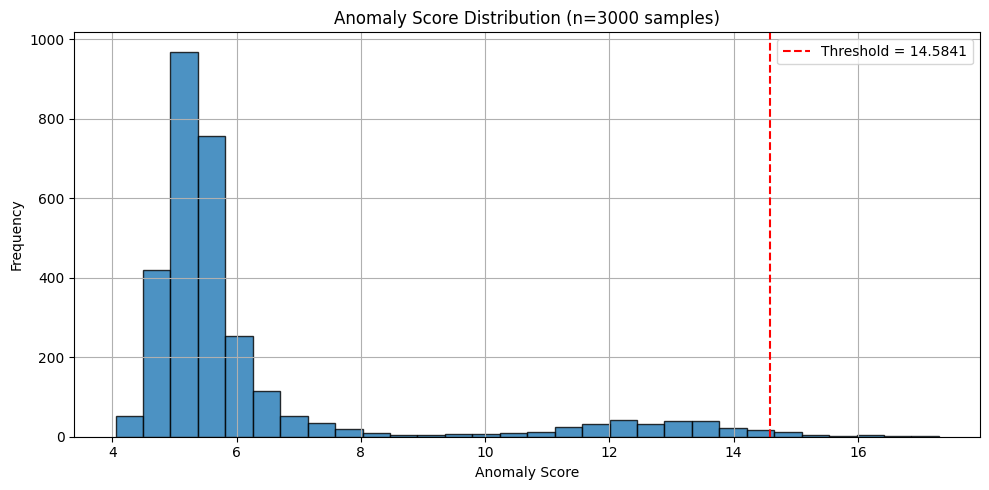

In [10]:

detector.plot_anomaly_score_distribution()

## predict_score_and_label

In [15]:
import numpy as np

df_one_slice = df_pandas[ df_pandas["slice_id"]=="S0001" ]

# Assume df_one_slice is your 170-row DataFrame
input_array = df_one_slice["avg_4gsnr"].values.reshape(1, -1)
result = detector.predict_score_and_label(input_array)
result

{'b ': array([5.312447], dtype=float32), 'is_outlier': array([False])}

## plot_series_btw_anomaly_and_normal

/tmp/ipython-input-5-4227056497.py:317: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', sample_n)


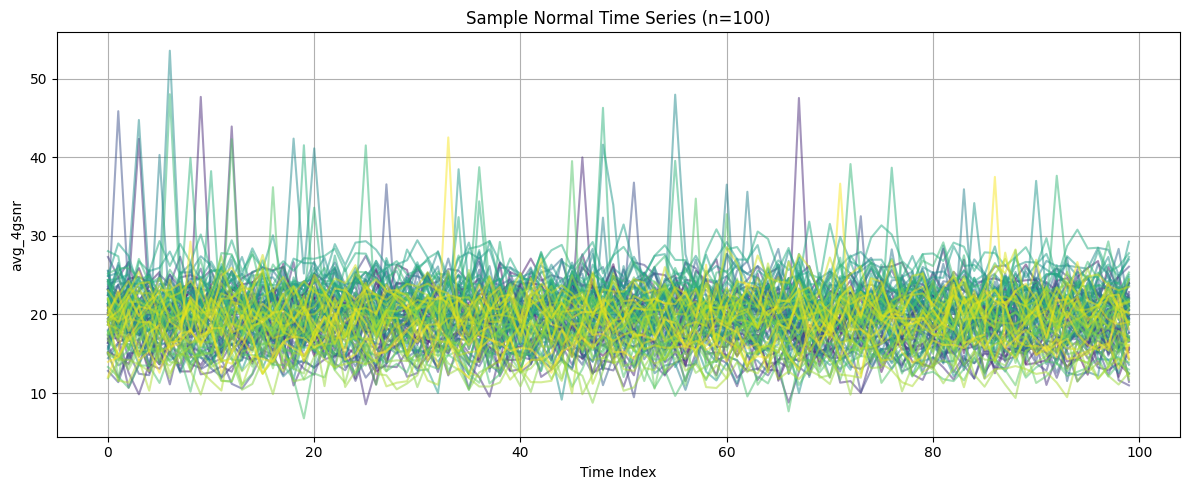

In [16]:

# Plot 100 normal samples
detector.plot_time_series_by_category(category="normal", n_samples=100)



/tmp/ipython-input-5-4227056497.py:317: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', sample_n)


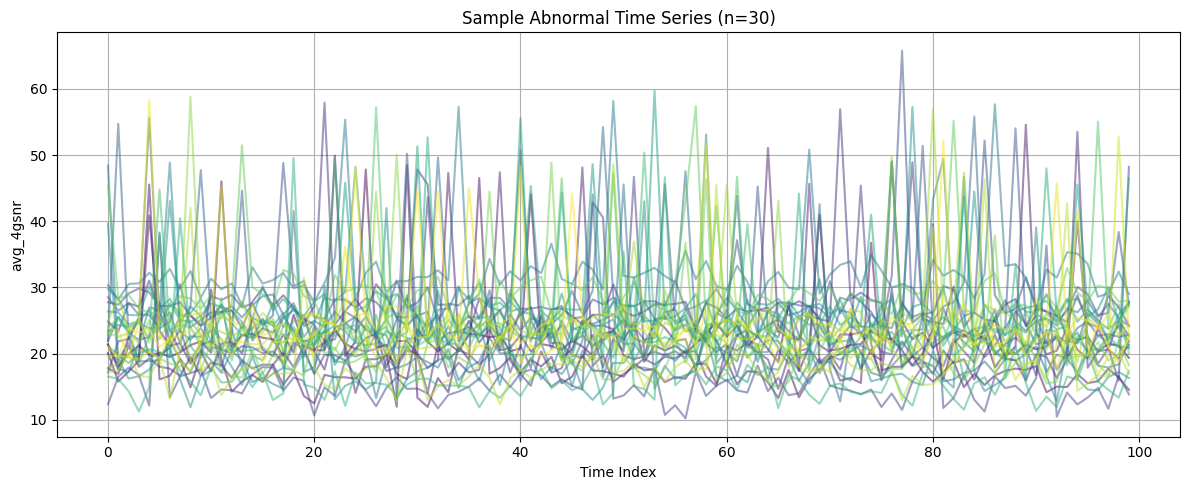

In [17]:

# Plot 100 abnormal samples
detector.plot_time_series_by_category(category="abnormal", n_samples=100)

/tmp/ipython-input-5-4227056497.py:317: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', sample_n)


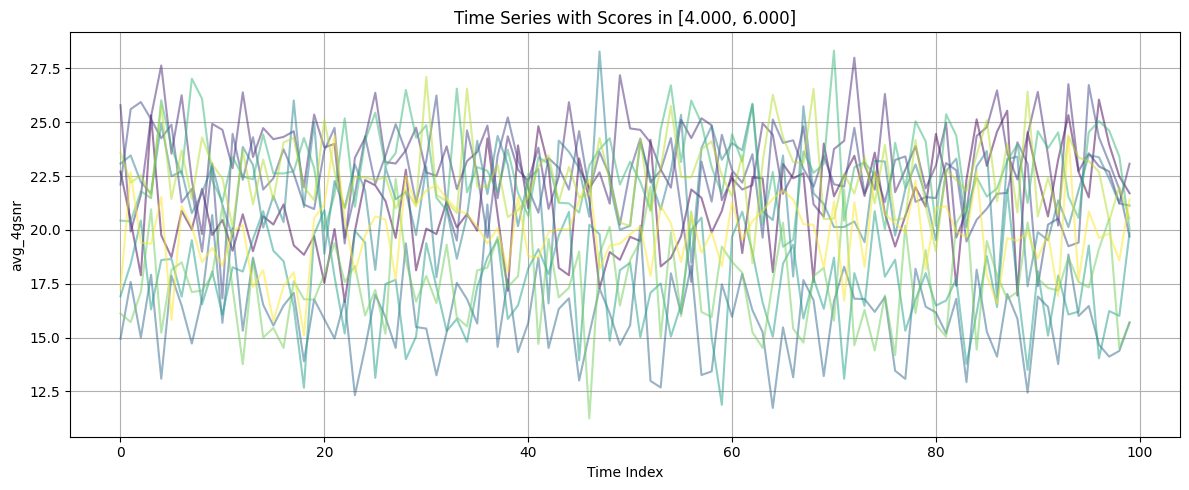

In [19]:




# Plot samples with scores in a specific range
detector.plot_time_series_by_category(category=(4, 6), n_samples=10)

/tmp/ipython-input-5-4227056497.py:317: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', sample_n)


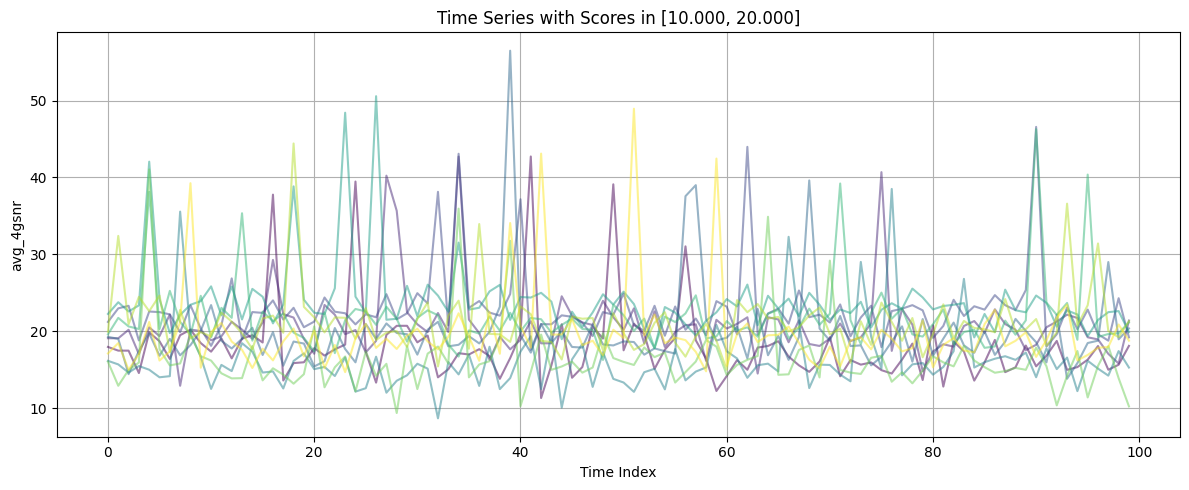

In [20]:




# Plot samples with scores in a specific range
detector.plot_time_series_by_category(category=(10,20), n_samples=10)

## plot_mean_and_spread

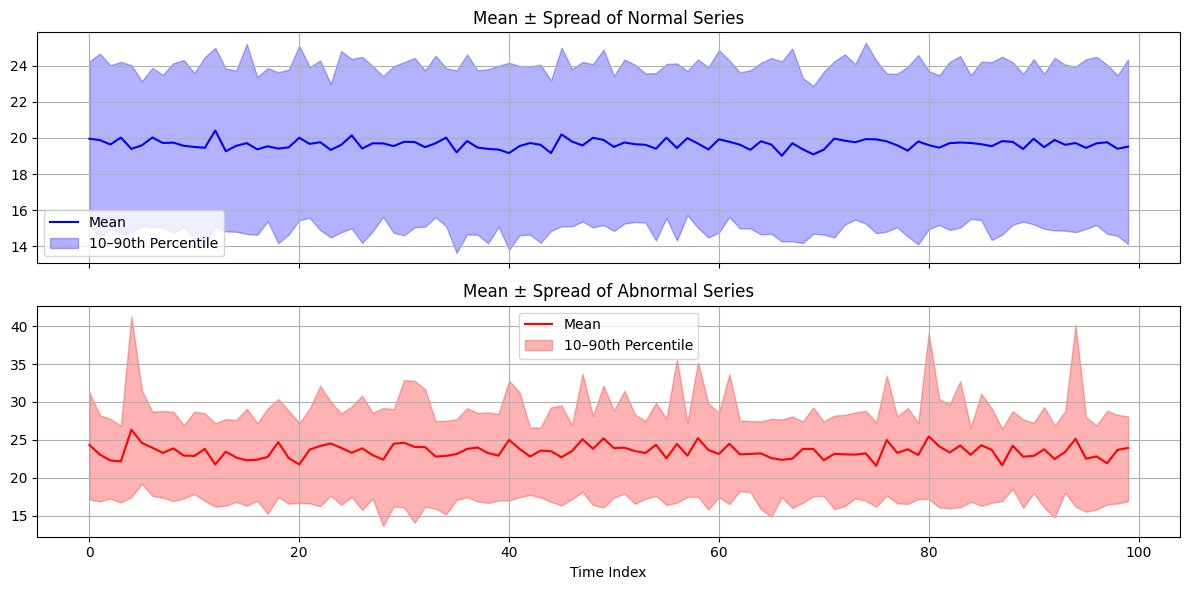

In [21]:

detector.plot_mean_and_spread()

## predict_and_compare_with_normal

In [ ]:

from matplotlib import cm
def predict_and_compare_with_normal(self,
                                    input_array: np.ndarray,
                                    title_id: str = "",
                                    n_normal_samples: int = 100,
                                    normal_score_range: Optional[Tuple[float, float]] = None):
    """
    Predict anomaly score of an input time series and compare it with normal training samples.

    Parameters
    ----------
    input_array : np.ndarray
        Shape (1, time_steps). The new time series to evaluate.
    title_id : str
        Identifier for labeling the input series on the plot.
    n_normal_samples : int
        Number of normal training series to plot for comparison.
    normal_score_range : tuple, optional
        If provided, defines (min_score, max_score) range to select normal samples
        from the training data. Overrides threshold-based selection.
    """
    if self.model is None or self.anomaly_scores is None:
        raise ValueError("Model not trained. Call fit() first.")

    # Ensure 2D shape for input
    if input_array.ndim == 1:
        input_array = input_array.reshape(1, -1)

    if self.scaler:
        input_array_scaled = self.scaler.transform(input_array)
    else:
        input_array_scaled = input_array

    scores = self.model.decision_function(input_array_scaled)
    labels = scores > self.threshold_scores

    # Select normal samples from training
    scores_all = self.anomaly_scores
    if normal_score_range is not None:
        min_score, max_score = normal_score_range
        normal_idx = np.where((scores_all >= min_score) & (scores_all <= max_score))[0]
    else:
        normal_idx = np.where(scores_all <= self.threshold_scores)[0]

    sample_n_normal = min(n_normal_samples, len(normal_idx))
    if sample_n_normal == 0:
        raise ValueError("No normal samples found in the specified range.")

    selected_idx = np.random.choice(normal_idx, size=sample_n_normal, replace=False)
    normal_samples = self.input_tensor[selected_idx, :, 0]

    # Plot
    plt.figure(figsize=(12, 5))
    cmap = cm.get_cmap('viridis', sample_n_normal)
    for i, series in enumerate(normal_samples):
        plt.plot(series, color=cmap(i), alpha=0.5)

    # Plot the input series
    input_series = input_array[0]
    label = 'Abnormal' if labels[0] else 'Normal'
    color = 'red' if labels[0] else 'darkgreen'
    plt.plot(input_series, linewidth=2.5, color=color, label=f"Input Series")

    # Add annotation in bottom-right
    annotation = (f"Score: {scores[0]:.4f}\n"
                  f"Thresh: {self.threshold_scores:.4f}\n"
                  f"Outlier: {label}")
    plt.annotate(annotation,
                 xy=(1.0, 0.0), xycoords='axes fraction',
                 xytext=(-10, 10), textcoords='offset points',
                 ha='right', va='bottom',
                 fontsize=9,
                 bbox=dict(boxstyle="round", fc="white", ec=color, alpha=0.8))

    plt.title(f"Comparison of Input Series with Normal Samples")
    plt.xlabel("Time Index")
    plt.ylabel(self.feature)
    plt.grid(True)
    plt.tight_layout()
    plt.show()



detector.predict_and_compare_with_normal = MethodType(predict_and_compare_with_normal, detector)


/tmp/ipython-input-5-4227056497.py:438: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', sample_n_normal)


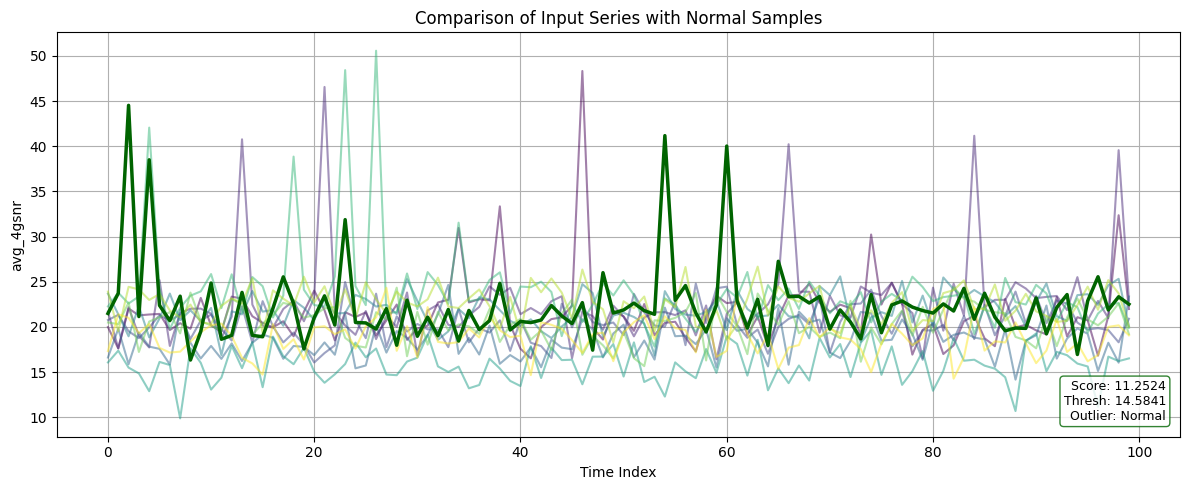

In [22]:

import numpy as np

df_one_slice = df_pandas[ df_pandas["slice_id"]=="S1001" ]

# Assume df_one_slice is your 170-row DataFrame
input_array = df_one_slice["avg_4gsnr"].values.reshape(1, -1)
detector.predict_and_compare_with_normal(input_array,
                                        n_normal_samples = 10,
                                        title_id = "S1001"
                                            )


/tmp/ipython-input-5-4227056497.py:438: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', sample_n_normal)


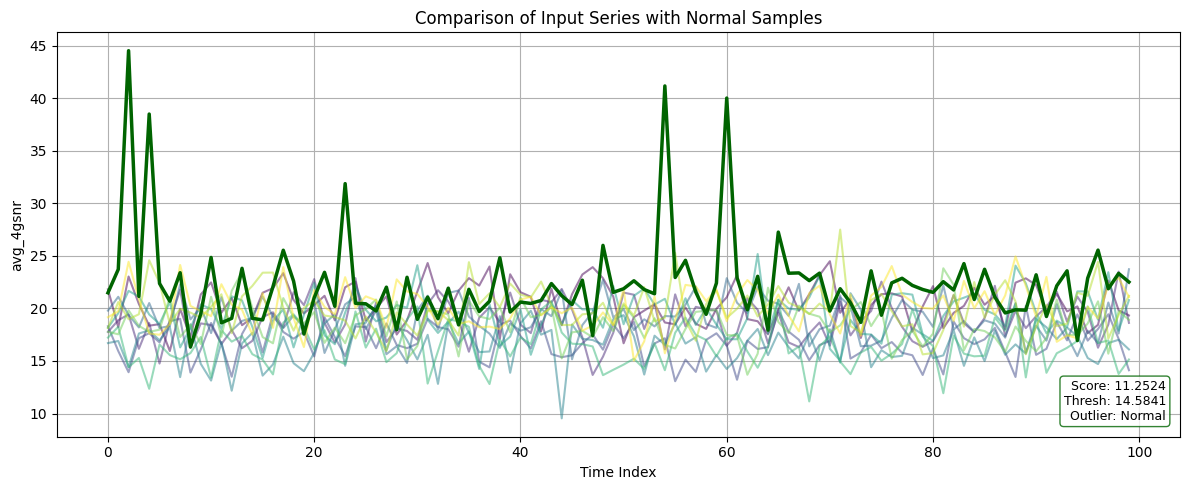

In [23]:

detector.predict_and_compare_with_normal(input_array,
                                        n_normal_samples = 10,
                                        title_id = "S1001",
                                        normal_score_range = [4,6]
                                            )

In [ ]:


import numpy as np
import matplotlib.pyplot as plt

dims = [2, 10, 50, 100, 200, 500]
avg_ratios = []

for d in dims:
    points = np.random.randn(1000, d)
    ref = points[0]
    dists = np.linalg.norm(points - ref, axis=1)
    ratio = (np.max(dists) - np.min(dists)) / np.mean(dists)
    avg_ratios.append(ratio)

plt.figure(figsize=(8, 5))
plt.plot(dims, avg_ratios, marker='o')
plt.title("Distance Contrast Vanishes in High Dimensions")
plt.xlabel("Dimensionality (d)")
plt.ylabel("(max - min) / mean distance")
plt.grid(True)
plt.show()


In [ ]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

errors = np.random.rand(168, 50)

plt.figure(figsize=(12, 6))
sns.heatmap(errors, cmap="YlOrRd", cbar_kws={'label': 'Numerical Value'})
plt.xlabel("Feature Index")
plt.ylabel("Hour of Week")
plt.title("Reconstruction Error Heatmap (1 Customer, 1 Week)")
plt.tight_layout()
plt.show()

